In [1]:
import pandas as pd 
import numpy as np 
import os
from distutils.dir_util import copy_tree, remove_tree
import cv2
import matplotlib.pyplot as plt
import warnings

In [3]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing import image, image_dataset_from_directory
from imblearn.over_sampling import SMOTE
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow import keras
from random import randint

In [5]:
default_dir = r"C:\Users\Sriya Reddy\Downloads\Alzheimers Data set\Alzheimer_s Dataset"
root_dir = "./"
test_dir = r"C:\Users\Sriya Reddy\Downloads\Alzheimers Data set\Alzheimer_s Dataset\test"
train_dir = r"C:\Users\Sriya Reddy\Downloads\Alzheimers Data set\Alzheimer_s Dataset\train"
work_dir = root_dir + "dataset/"

if os.path.exists(work_dir):
    remove_tree(work_dir)
    

os.mkdir(work_dir)
copy_tree(train_dir, work_dir)
#copy_tree(test_dir, work_dir)
print("Working Directory Contents:", os.listdir(work_dir))

Working Directory Contents: ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']


In [6]:
CLASSES = [ 'NonDemented',
            'VeryMildDemented',
            'MildDemented',
            'ModerateDemented']

IMG_SIZE = 176 

IMAGE_SIZE = [176, 176]
DIM = (IMG_SIZE, IMG_SIZE)

In [7]:
ZOOM = [.99, 1.01]
BRIGHT_RANGE = [0.8, 1.2]
HORZ_FLIP = True
FILL_MODE = "constant"
DATA_FORMAT = "channels_last"

image_generator = ImageDataGenerator(rescale = 1./255, brightness_range=BRIGHT_RANGE, zoom_range=ZOOM, 
                                     data_format=DATA_FORMAT, fill_mode=FILL_MODE, horizontal_flip=HORZ_FLIP)

In [11]:
train_dataset = image_generator.flow_from_directory(batch_size=5200,
                                                    directory=work_dir,
                                                    target_size=(176, 176),
                                                    shuffle= True)

Found 5121 images belonging to 4 classes.


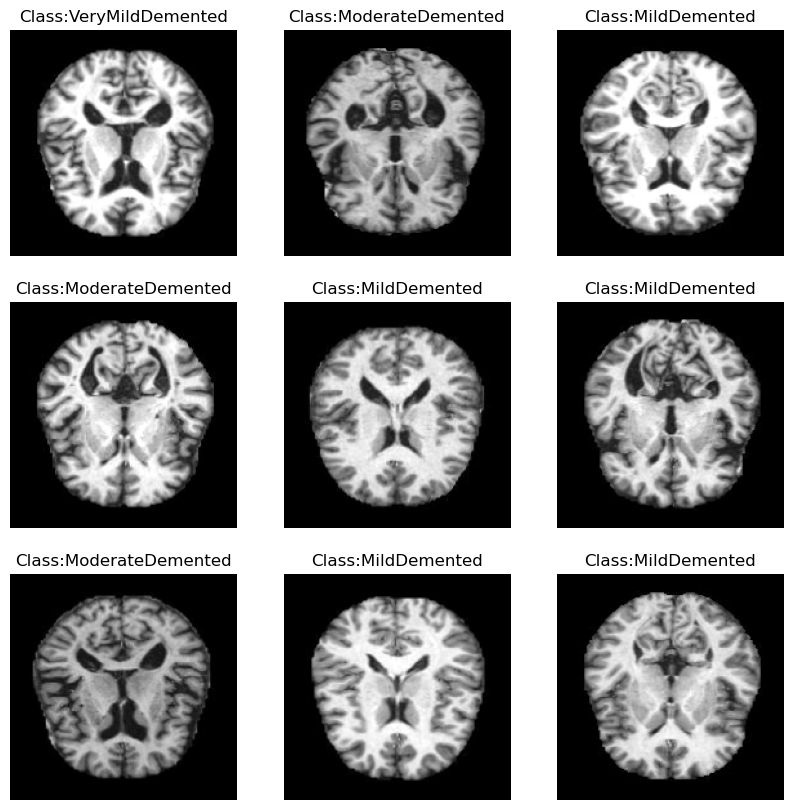

In [13]:
def show_images(generator,y_pred=None):
  
    labels =dict(zip([0,1,2,3], CLASSES))
    
    # get a lot of images
    x, y = next(generator)
    
    
    # show a grid of 9 images
    plt.figure(figsize=(10, 10))
    if y_pred is None:
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            idx = randint(0,50)
            plt.imshow(x[idx])
            plt.axis("off")
            plt.title("Class:{}".format(labels[np.argmax(y[idx])]))
                                                     
    else:
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(x[i])
            plt.axis("off")
            plt.title("Actual:{} \nPredicted:{}".format(labels[np.argmax(y[i])],labels[y_pred[i]]))
    
# Display Train Images
show_images(train_dataset)

<BarContainer object of 4 artists>

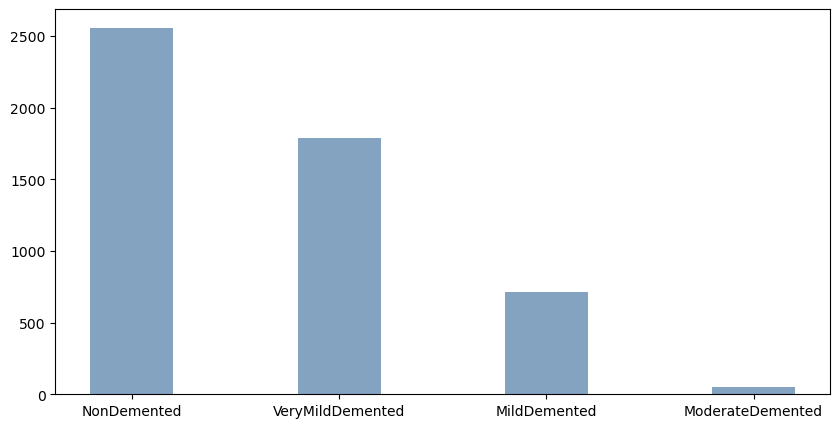

In [31]:
data = {'NonDemented':      0, 
        'VeryMildDemented': 0, 
        'MildDemented':     0,
        'ModerateDemented': 0}

# visualizing dataset
for cls in os.listdir(work_dir):
    for img in os.listdir(work_dir + '/' + cls):
        data[cls] = data[cls] + 1
        
keys = list(data.keys())
values = list(data.values())
  
fig = plt.figure(figsize = (10, 5))
 
plt.bar(keys, values, color=(0.2, 0.4, 0.6, 0.6), width = 0.4)

In [33]:
train_data, train_labels = next(train_dataset)


In [34]:
print(train_data.shape, train_labels.shape)

(5121, 176, 176, 3) (5121, 4)


In [35]:
#resampling data

sm = SMOTE(random_state=42)

train_data, train_labels = sm.fit_resample(train_data.reshape(-1, IMG_SIZE * IMG_SIZE * 3), train_labels)

train_data = train_data.reshape(-1, IMG_SIZE, IMG_SIZE, 3)

print(train_data.shape, train_labels.shape)

(10240, 176, 176, 3) (10240, 4)


In [39]:
from sklearn.model_selection import train_test_split
train_data, test_data, train_labels, test_labels = train_test_split(train_data, train_labels, test_size = 0.2, random_state=42)
train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, test_size = 0.2, random_state=42)

In [41]:
model = keras.models.Sequential([
    # Convolutional layers
    keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=[176, 176, 3]),
    keras.layers.MaxPooling2D(),
    keras.layers.Conv2D(32, (2, 2), activation='relu'),
    keras.layers.MaxPooling2D(),

    keras.layers.SeparableConv2D(64, 3, activation='relu', padding='same'),
    keras.layers.SeparableConv2D(64, 3, activation='relu', padding='same'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(),

    keras.layers.SeparableConv2D(128, 3, activation='relu', padding='same'),
    keras.layers.SeparableConv2D(128, 3, activation='relu', padding='same'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(),
    keras.layers.Dropout(0.2),

    keras.layers.SeparableConv2D(256, 3, activation='relu', padding='same'),
    keras.layers.SeparableConv2D(256, 3, activation='relu', padding='same'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(),
    keras.layers.Dropout(0.2),

    # Flatten the output
    keras.layers.Flatten(),
   
    # Reshape to prepare for RNN layer
    keras.layers.Reshape((256, -1)),  # Adjust dimensions based on feature maps

    # Add an RNN layer (e.g., LSTM)
    keras.layers.LSTM(64, return_sequences=False),  # or use GRU, SimpleRNN

    # Fully connected layers
    keras.layers.Dense(512, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.7),

    keras.layers.Dense(128, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.5),

    keras.layers.Dense(64, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.3),

    # Output layer
    keras.layers.Dense(4, activation='softmax')
])


C:\Users\Sriya Reddy\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [43]:
model.compile(
        optimizer='adam',
        loss=tf.losses.CategoricalCrossentropy(),
        metrics=[tf.keras.metrics.CategoricalAccuracy(name='acc'),
                 keras.metrics.AUC(name='auc')]
    )

In [45]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 174, 174, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 87, 87, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 86, 86, 32)          │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 43, 43, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ separable_conv2d (SeparableConv2D)   │ (None, 43, 43, 64)          │           2,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ separable_conv2d_1 (SeparableConv2D) │ (None, 43, 43, 64)          │           4,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 43, 43, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 21, 21, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ separable_conv2d_2 (SeparableConv2D) │ (None, 21, 21, 128)         │           8,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ separable_conv2d_3 (SeparableConv2D) │ (None, 21, 21, 128)         │          17,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 21, 21, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 10, 10, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 10, 10, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ separable_conv2d_4 (SeparableConv2D) │ (None, 10, 10, 256)         │          34,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ separable_conv2d_5 (SeparableConv2D) │ (None, 10, 10, 256)         │          68,096 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 10, 10, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 5, 5, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 5, 5, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 6400)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 256, 25)             │              

 Total params: 273,604 (1.04 MB)

 Trainable params: 271,300 (1.03 MB)

 Non-trainable params: 2,304 (9.00 KB)

In [47]:
history = model.fit(train_data, train_labels, validation_data=(val_data, val_labels), epochs=50)

Epoch 1/50
205/205 ━━━━━━━━━━━━━━━━━━━━ 69s 273ms/step - acc: 0.2574 - auc: 0.5086 - loss: 1.9390 - val_acc: 0.2465 - val_auc: 0.5036 - val_loss: 1.4245
Epoch 2/50
205/205 ━━━━━━━━━━━━━━━━━━━━ 53s 260ms/step - acc: 0.2653 - auc: 0.5283 - loss: 1.5673 - val_acc: 0.2465 - val_auc: 0.5046 - val_loss: 1.4218
Epoch 3/50
205/205 ━━━━━━━━━━━━━━━━━━━━ 53s 260ms/step - acc: 0.3050 - auc: 0.5678 - loss: 1.4395 - val_acc: 0.4167 - val_auc: 0.6446 - val_loss: 1.3909
Epoch 4/50
205/205 ━━━━━━━━━━━━━━━━━━━━ 52s 253ms/step - acc: 0.5430 - auc: 0.8127 - loss: 1.0105 - val_acc: 0.6516 - val_auc: 0.8919 - val_loss: 0.7665
Epoch 5/50
205/205 ━━━━━━━━━━━━━━━━━━━━ 53s 256ms/step - acc: 0.6258 - auc: 0.8833 - loss: 0.7930 - val_acc: 0.3276 - val_auc: 0.6865 - val_loss: 1.8224
Epoch 6/50
205/205 ━━━━━━━━━━━━━━━━━━━━ 53s 257ms/step - acc: 0.6365 - auc: 0.8918 - loss: 0.7604 - val_acc: 0.2465 - val_auc: 0.5300 - val_loss: 3.8014
Epoch 7/50
205/205 ━━━━━━━━━━━━━━━━━━━━ 52s 253ms/step - acc: 0.6712 - auc: 0.9074

In [38]:
loss, auc, accuracy = model.evaluate(test_data, test_labels)
print("Loss: ", loss)
print("Accuracy: ", accuracy)

64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - acc: 0.9026 - auc: 0.9891 - loss: 0.2810
Loss:  0.31642377376556396
Accuracy:  0.9860087633132935


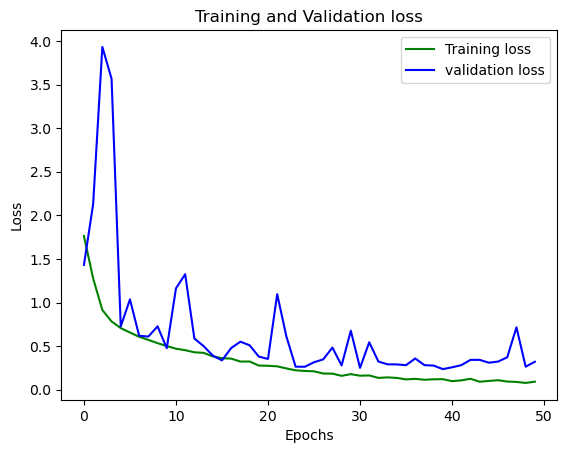

In [40]:
loss_train = history.history['loss']
loss_val = history.history['val_loss']
epochs = range(0,50)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

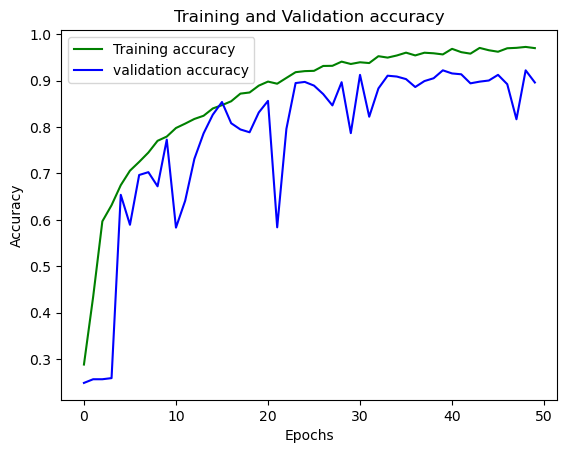

In [42]:
acc_train = history.history['acc']
acc_val = history.history['val_acc']
epochs = range(0,50)
plt.plot(epochs, acc_train, 'g', label='Training accuracy')
plt.plot(epochs, acc_val, 'b', label='validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [44]:
model.save('my_model.h5')

In [46]:
from pathlib import Path
from PIL import Image
from tensorflow.keras.preprocessing.image import load_img, img_to_array
#Image path 
path = Path('dataset/ModerateDemented/moderateDem0.jpg')
img = image.load_img(path, target_size=(176,176))
image_array = img_to_array(img) / 255.0
image_array = np.expand_dims(image_array, axis=0)

img_array = image_array.reshape((1, 176, 176, 3))


predictions = model.predict(image_array)

#print(predictions)
predicted_label = train_labels[np.argmax(predictions)]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 581ms/step
